In [1]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from tqdm.notebook import tnrange, tqdm_notebook

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from model.helpers import DEFAULT_PARAMS, dict2spec, update_dict, spawn_dict
from model.simulation import simulate_single_pass

In [4]:
import model.objects

default_params = update_dict(DEFAULT_PARAMS, {
    'scene.max_distance': 12.0,
    'reader.position': (-5.0, 0.0, 6.25),
    'reader.speed': (2.0, 0.0, 0.0),
    'channel_type': model.objects.AWGNChannelSpec,
    'channel.frequency': 860e6,
#     'channel.connection_distance': 11.0,
})

In [5]:
from model.des.pyscheduler import PyScheduler
default_spec = dict2spec(default_params)
# _, default_scene = simulate_single_pass(default_spec, PyScheduler)

In [6]:
def map_prod(m1, m2):
    xy = [(x, m2.get(t)) for t, x in zip(m1.time, m1.values)]
    xy.sort(key=lambda r: r[0])
    return xy
    
def get_ber_over_x(scene):
    chan = scene.channel
    xy = map_prod(chan.dx_map, chan.ber_map)
    x = [x for x, _ in xy]
    y = [y for _, y in xy]
    return x, y

In [ ]:
alt_ber_values = [5.0, 5.5, 6.0, 6.25, 6.5, 7.0]
alt_ber_params = spawn_dict(default_params, 'reader.position', [(-5.0, 0.0, z) for z in alt_ber_values])
alt_ber_rets = [simulate_single_pass(dict2spec(p)) for p in tqdm_notebook(alt_ber_params)]
# plot_ber_over_x(default_scene)

TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 53, in update_positions
    channel.update_power(time, reader, tag)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 153, in update_power
    pl = self._get_path_loss(d)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 210, in _get_path_loss
    return lin2db(free_space_path_loss(d, wavelen))
TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'


KeyboardInterrupt: 

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 250, in no_reply
    send_command(ctx, reader.commands.query_rep)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 84, in send_command
    sim.schedule(time + prop, ev.TAG_RX_START, att=frame)
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 248, in no_reply
    if reader.has_next_slot():
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/reader.py", line 137, in has_next_slot
    def has_next_slot(self):
KeyboardInterrupt: 


TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 53, in update_positions
    channel.update_power(time, reader, tag)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 153, in update_power
    pl = self._get_path_loss(d)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 210, in _get_path_loss
    return lin2db(free_space_path_loss(d, wavelen))
TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'


KeyboardInterrupt: 

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 252, in no_reply
    reader_start_round(ctx)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 100, in reader_start_round
    send_command(ctx, frame)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 83, in send_command
    prop = channel.get_propagation_delay(reader.position, tag.position)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 137, in get_propagation_delay
    return np.linalg.norm(reader_pos - tag_pos) / self.speed_of_light
KeyboardInterrupt: 


In [ ]:
alt_ber_xy_list = [get_ber_over_x(scene) for _, scene in alt_ber_rets]
for i, (x, y) in enumerate(alt_ber_xy_list):
    plt.plot(x, y, label=f'Высота {alt_ber_values[i]}м')
plt.grid()
plt.legend()
plt.xlabel('Расстояние между меткой и считывателем по X')
plt.ylabel('Вероятность битовой ошибки (BER)')
plt.title('Изменение BER при движении считывателя на разных высотах\nОднолучевая модель, AWGN-канал')
plt.savefig('ber_alt.pdf')

In [8]:
from model.des.cyscheduler import CyScheduler

def estimate_probs(spec, num_iters=10, scheduler=CyScheduler, leave_tqdm=True):
    rets = [simulate_single_pass(spec, scheduler) for _ in tnrange(num_iters, leave=leave_tqdm)]
    
    def divide(x, y, default=0.0):
        return x / y if y != 0 else default
    
    identified = [1. if scene.tag.num_epcid_received > 0 else 0 for (_, scene) in rets]
    transmitted = [1. if scene.tag.num_data_received > 0 else 0 for (_, scene) in rets]
    return np.mean(identified), np.mean(transmitted)

In [ ]:
estimate_probs(default_spec, 10)

TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'

Exception ignored in: 'model.des.cyscheduler.cy_callback_e'
Traceback (most recent call last):
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/handlers/handlers.py", line 53, in update_positions
    channel.update_power(time, reader, tag)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 153, in update_power
    pl = self._get_path_loss(d)
  File "/Users/andrey/workspace/lab69/uav-rfid-sim/src/model/objects/channel.py", line 210, in _get_path_loss
    return lin2db(free_space_path_loss(d, wavelen))
TypeError: free_space_path_loss() missing 1 required positional argument: 'wavelen'


In [7]:
speed_values = np.linspace(1, 11, 20)
speeds = [(x, 0.0, 0.0) for x in speed_values]
speed_params_base = update_dict(default_params, {
    'scene.position_update_interval': 0.01, 
    'reader.position': (-5, 0, 6.25),
    'scene.max_distance': 10.0,
})
speed_params = spawn_dict(speed_params_base, 'reader.speed', speeds)
speed_probs = [estimate_probs(dict2spec(p), scheduler=CyScheduler, num_iters=30, leave_tqdm=False) 
               for p in tqdm_notebook(speed_params)]

NameError: name 'estimate_probs' is not defined

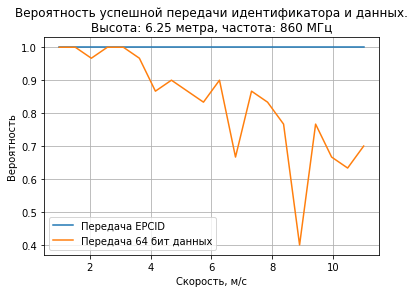

In [30]:
speed_id_probs = [v for v, _ in speed_probs]
speed_data_probs = [v for _, v in speed_probs]
x = speed_values

plt.plot(x, speed_id_probs, label='Передача EPCID')
plt.plot(x, speed_data_probs, label="Передача 64 бит данных")
plt.legend()
plt.title('Вероятность успешной передачи идентификатора и данных.\n'
          'Высота: 6.25 метра, частота: 860 МГц')
plt.xlabel('Скорость, м/с')
plt.ylabel('Вероятность')
plt.grid()
plt.savefig('prob_vs_speed.pdf')

In [ ]:
alt_values = np.linspace(6.0, 7.5, 12)
alt_positions = [(-5.0, 0.0, z) for z in alt_values]
alt_params_base = update_dict(default_params, {
    'scene.position_update_interval': 0.01, 
    'reader.speed': (5.0, 0, 0.0),
    'scene.max_distance': 10.0,
})
alt_params = spawn_dict(alt_params_base, 'reader.position', alt_positions)
alt_probs = [estimate_probs(dict2spec(p), scheduler=CyScheduler, num_iters=20, leave_tqdm=False) 
               for p in tqdm_notebook(alt_params)]

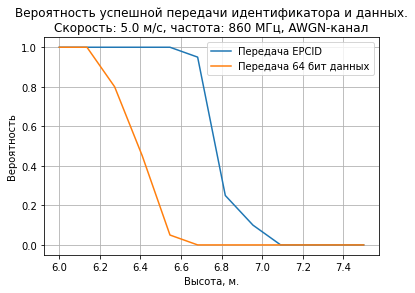

In [28]:
alt_id_probs = [v for v, _ in alt_probs]
alt_data_probs = [v for _, v in alt_probs]
x = alt_values

plt.plot(x, alt_id_probs, label='Передача EPCID')
plt.plot(x, alt_data_probs, label="Передача 64 бит данных")
plt.legend()
plt.title('Вероятность успешной передачи идентификатора и данных.\n'
          'Скорость: 5.0 м/c, частота: 860 МГц, AWGN-канал')
plt.xlabel('Высота, м.')
plt.ylabel('Вероятность')
plt.grid()
plt.savefig('prob_vs_alt.pdf')

## Theoretic channel estimation

In [7]:
from model.radio.radio import lin2db, free_space_path_loss, dipole_rp, dbm2w, w2dbm
from model.objects.channel import SPEED_OF_LIGHT, THERMAL_NOISE

from collections import namedtuple

from matplotlib.cm import get_cmap
CMAP = get_cmap('inferno')

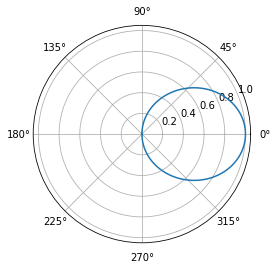

In [8]:
angles = np.linspace(-np.pi/2, np.pi/2, 100)
plt.polar(angles, [dipole_rp(a) for a in angles])
plt.savefig('plots/dipole_rp.png')

In [9]:
H0 = 5.0
H = np.asarray([2., 3, 4, 5., 6., 7., 8., 9., 10., 11])
P = np.asarray([16.0, 18.0, 20.0, 22.0, 25.0, 28.0, 31.0])
X = np.linspace(-20.0, 20.0, 2000)

FREQUENCY = 900e6
WAVELEN = SPEED_OF_LIGHT / FREQUENCY

TAG_GAIN = 2.0
READER_GAIN = 7.0
MODULATION_LOSS = -10.0
POLARIZATION_LOSS = -3.0
READER_TX_POWER = 31.5
TAG_SENSITIVITY = -22.0

def const_rp(alpha):
    return 1.0

In [10]:
def get_tag_rx_power(x, height, reader_tx_power=READER_TX_POWER, wavelen=WAVELEN, *, pl=None):
    if pl is None:
        d = (x**2 + height**2) ** 0.5
        pl_lin = free_space_path_loss(d, height, wavelen, rp_rx=dipole_rp, rp_tx=dipole_rp)
        pl = lin2db(pl_lin)
    return reader_tx_power + pl + READER_GAIN + TAG_GAIN + POLARIZATION_LOSS

def get_tag_tx_power(tag_rx_power, truncate=False):
    if truncate and tag_rx_power < TAG_SENSITIVITY:
        return THERMAL_NOISE
    return tag_rx_power + MODULATION_LOSS

def get_reader_rx_power(x, height, tag_tx_power, wavelen=WAVELEN, truncate=False, *, pl=None):
    if pl is None:
        d = (x**2 + height**2) ** 0.5
        pl_lin = free_space_path_loss(d, height, wavelen, rp_rx=dipole_rp, rp_tx=dipole_rp)
        pl = lin2db(pl_lin)
    if truncate and tag_tx_power - MODULATION_LOSS < TAG_SENSITIVITY:
        return THERMAL_NOISE
    return tag_tx_power + pl + READER_GAIN + TAG_GAIN + POLARIZATION_LOSS

In [11]:
EstimateResult = namedtuple('EstimateResult', 
                            ('pathloss', 'tag_rx', 'tag_tx', 'reader_rx', 'ox', 'height', 
                             'p_tx', 'wavelen')
                           )

def estimate_power(ox, height, p_tx, wavelen):
    pl = [
        lin2db(
            free_space_path_loss(
                (x**2 + height**2)**0.5, 
                height, 
                wavelen, 
                rp_rx=dipole_rp, 
                rp_tx=dipole_rp
            )
        )
        for x in ox
    ]
    tag_rx = [
        get_tag_rx_power(x, height, p_tx, wavelen, pl=a_pl) 
        for x, a_pl in zip(ox, pl)
    ]
    tag_tx = [get_tag_tx_power(p) for p in tag_rx]
    tag_tx_t = [get_tag_tx_power(p, truncate=True) for p in tag_rx]
    reader_rx = [
        get_reader_rx_power(x, height, p, wavelen, truncate=False, pl=a_pl)
        for x, p, a_pl in zip(ox, tag_tx, pl)
    ]
    reader_rx_trunc = [
        get_reader_rx_power(x, height, p, wavelen, truncate=True)
        for x, p in zip(ox, tag_tx)
    ]
    return EstimateResult(pl, tag_rx, tag_tx_t, reader_rx_trunc,
                         ox=ox, height=height, p_tx=p_tx, wavelen=wavelen)

In [12]:
EXP_H5P28 = estimate_power(X, height=5.0, p_tx=28.0, wavelen=WAVELEN)

In [13]:
LANG = 'rus'

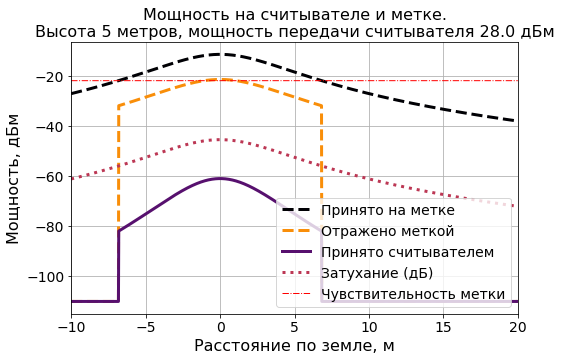

In [35]:
STRINGS = {
    'title': {
        'rus': f"Мощность на считывателе и метке.\nВысота 5 метров, мощность передачи считывателя 28.0 дБм",
        'eng': f"Tag and reader estimated power.\nHeight: 5 meters, Reader TX power: 28.0 dBm",
    },
    'x-axis': {'rus': "Расстояние по земле, м", 'eng': "Ground distance, m"},
    'y-axis': {'rus': "Мощность, дБм", 'eng': "Power, dBm"},
    'tag-rx': {'rus': "Принято на метке", 'eng': "Tag RX power"},
    'tag-tx': {'rus': "Отражено меткой", 'eng': "Tag TX power"},
    'reader-rx': {'rus': "Принято считывателем", 'eng': "Reader RX power"},
    'pathloss': {'rus': "Затухание (дБ)", 'eng': "Path loss (dB)"},
    'sensitivity': {'rus': "Чувствительность метки", 'eng': "Tag sensitivity"}
}
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(X, EXP_H5P28.tag_rx, label=STRINGS['tag-rx'][LANG], linewidth=3, linestyle="--", color=CMAP(0))
ax.plot(X, EXP_H5P28.tag_tx, label=STRINGS['tag-tx'][LANG], linewidth=3, linestyle="--", color=CMAP(0.75))
ax.plot(X, EXP_H5P28.reader_rx, label=STRINGS['reader-rx'][LANG], linewidth=3, linestyle="-", color=CMAP(0.25))
ax.plot(X, EXP_H5P28.pathloss, label=STRINGS['pathloss'][LANG], linewidth=3, linestyle=":", color=CMAP(0.5))
ax.plot(X, [TAG_SENSITIVITY]*len(X), linewidth=1, linestyle='-.', color='red', label=STRINGS['sensitivity'][LANG])
ax.grid()
ax.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
ax.set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
ax.set_xlim((-10, 20))
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, loc='lower right')
ax.set_title(STRINGS['title'][LANG], fontsize=16)
plt.savefig(f"plots/channel_budget_{LANG}.pdf")

### Power for different heights and tx powers

In [20]:
HXP28_POWER = [estimate_power(X, height=h, p_tx=28.0, wavelen=WAVELEN) for h in tqdm_notebook(H, leave=False)]
H4PX_POWER = [estimate_power(X, height=4.0, p_tx=p, wavelen=WAVELEN) for p in tqdm_notebook(P, leave=False)]

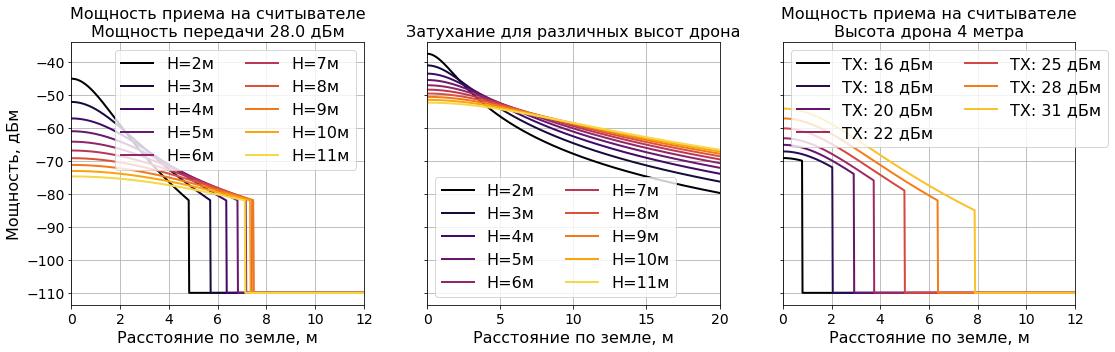

In [42]:
STRINGS = {
    'x-axis': {'eng': 'Ground distance, m', 'rus': 'Расстояние по земле, м'},
    'y-axis': {'eng': 'Power, dBm', 'rus': 'Мощность, дБм'},
    'm': {'eng': 'm', 'rus': 'м'},
    'dbm': {'eng': 'dBm', 'rus': 'дБм'},
    'title-rx-for-fixed-tx': {
        'eng': 'RX power at reader, TX power = 28.0 dBm',
        'rus': 'Мощность приема на считывателе\nМощность передачи 28.0 дБм',
    },
    'title-pathloss': {
        'eng': "Path loss for different altitudes",
        'rus': 'Затухание для различных высот дрона',
    },
    'title-rx-for-fixed-alt': {
        'eng': "RX power at reader, altitude = 4 meters",
        'rus': 'Мощность приема на считывателе\nВысота дрона 4 метра'
    }
}

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)
for i, h in enumerate(H):
    ax0.plot(X, HXP28_POWER[i].reader_rx, 
             label=f"H={h:.0f}{STRINGS['m'][LANG]}", 
             linewidth=2, color=CMAP(i/len(H)))
    ax1.plot(X, HXP28_POWER[i].pathloss, 
             label=f"H={h:.0f}{STRINGS['m'][LANG]}", 
             linewidth=2, color=CMAP(i/len(H)))
for i, p in enumerate(P):
    ax2.plot(X, H4PX_POWER[i].reader_rx, 
             label=f"TX: {p:.0f} {STRINGS['dbm'][LANG]}", 
             linewidth=2, color=CMAP(i/len(P)))
for ax in (ax0, ax1, ax2):
    ax.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
    ax.grid()
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=16, ncol=2)
ax0.set_xlim((0, 12))
ax1.set_xlim((0, 20))
ax2.set_xlim((0, 12))
ax0.set_title(STRINGS['title-rx-for-fixed-tx'][LANG], fontsize=16)
ax1.set_title(STRINGS['title-pathloss'][LANG], fontsize=16)
ax2.set_title(STRINGS['title-rx-for-fixed-alt'][LANG], fontsize=16)
ax0.set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/reader_rx_power_{LANG}.pdf')

### SNR and BER estimation

In [43]:
from model.radio.radio import snr_extended, sync_angle, signal2noise, ber_over_awgn
from model.c1g2.replies import TagPreamble
from model.c1g2.symbols import TagEncoding, get_blf, DR

In [44]:
TAG_ENCS = [TagEncoding.FM0, TagEncoding.M2, TagEncoding.M4, TagEncoding.M8]
TREXTS = [False, True]
TARIS = [6.25e-6, 12.5e-6, 18.75e-6, 25e-6]
RTCALS = [t * 2.5 for t in TARIS]
TRCALS = [t * 1.5 for t in RTCALS]

NOISE = w2dbm(dbm2w(-114.0) + dbm2w(-80.0))

FAST_TARI = TARIS[0]
FAST_RTCAL = RTCALS[0]
FAST_TRCAL = TRCALS[0]
FAST_ENC = TagEncoding.FM0
FAST_TREXT = False
FAST_DR = DR.DR_643

MED_TARI = TARIS[1]
MED_RTCAL = RTCALS[1]
MED_TRCAL = TRCALS[1]
MED_ENC = TagEncoding.M4
MED_TREXT = False
MED_DR = DR.DR_8

SLOW_TARI = TARIS[3]
SLOW_RTCAL = RTCALS[3]
SLOW_TRCAL = TRCALS[3]
SLOW_ENC = TagEncoding.M8
SLOW_TREXT = True
SLOW_DR = DR.DR_8

CODING_SETS = [
    (FAST_TARI, FAST_TRCAL, FAST_ENC, FAST_TREXT, FAST_DR),
    (TARIS[1], TRCALS[1], TagEncoding.FM0, False, DR.DR_643),
    (MED_TARI, MED_TRCAL, MED_ENC, True, MED_DR),    
    (SLOW_TARI, SLOW_TRCAL, SLOW_ENC, SLOW_TREXT, SLOW_DR),
]

print(NOISE)

-79.99827138659009


In [45]:
def get_snr_ext(snr_list, m, trext, tari, trcal, dr):
    blf = get_blf(dr, trcal)
    preamble = TagPreamble(m, trext, blf)
    symbol = 1. / blf
    ret = [0] * len(snr_list)
    for i, snr in enumerate(snr_list):
        phi = sync_angle(snr, preamble_duration=preamble.duration)
        ret[i] = snr_extended(snr, phi, m.value, symbol)
    return ret

def estimate_raw_snr(p_rx):
    return [signal2noise(p, NOISE) for p in p_rx]

def estimate_snr(p_rx):
    raw_snr = [signal2noise(p, NOISE) for p in p_rx]
    d = {}
    for (tari, trcal, enc, trext, dr), key in zip(CODING_SETS, ('fast', 'med_0', 'med_1', 'slow')):
        d[key] = get_snr_ext(raw_snr, enc, trext, tari, trcal, dr)
    return d
        
def estimate_ber(snr_dict):
    try:
        return {
            key: [ber_over_awgn(snr) for snr in value]
            for key, value in snr_dict.items()
        }
    except AttributeError:
        return [ber_over_awgn(snr) for snr in snr_dict]

In [46]:
HXP28_RAW_SNR = [estimate_raw_snr(rec.reader_rx) for rec in HXP28_POWER]
H4PX_RAW_SNR = [estimate_raw_snr(rec.reader_rx) for rec in H4PX_POWER]

HXP28_RAW_BER = [estimate_ber(snr) for snr in HXP28_RAW_SNR]
H4PX_RAW_BER = [estimate_ber(snr) for snr in H4PX_RAW_SNR]

HXP28_SNR = [estimate_snr(rec.reader_rx) for rec in HXP28_POWER]
H4PX_SNR = [estimate_snr(rec.reader_rx) for rec in H4PX_POWER]

HXP28_BER = [estimate_ber(snr_dict) for snr_dict in HXP28_SNR]
H4PX_BER = [estimate_ber(snr_dict) for snr_dict in H4PX_SNR]

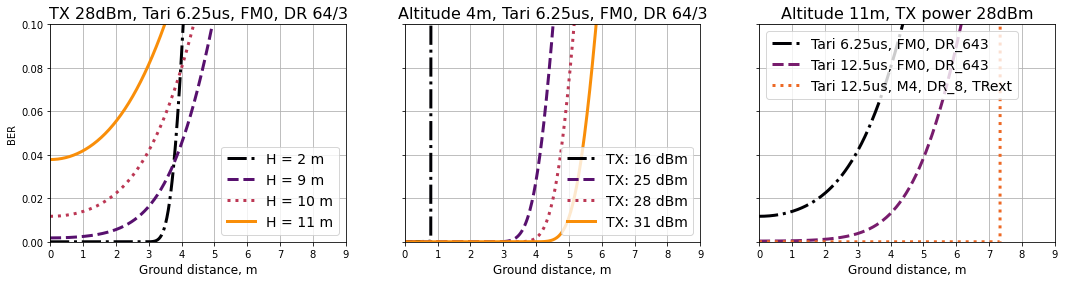

In [42]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(18,4))

_hx_bers = HXP28_BER[:1] + HXP28_BER[-3:]
_hx_h = list(H[:1]) + list(H[-3:])
_px_bers = H4PX_BER[:1] + H4PX_BER[-3:]
_px_h = list(P[:1]) + list(P[-3:])
styles = ["-.", "--", ":", "-"]

for i, (height, bers, ls) in enumerate(zip(_hx_h, _hx_bers, styles)):
    ax0.plot(X, bers['fast'], label=f'H = {height:.0f} m',
             linestyle=ls, linewidth=3, color=CMAP(i/4))

for i, (p, bers, ls) in enumerate(zip(_px_h, _px_bers, styles)):
    ax1.plot(X, bers['fast'], label=f'TX: {p:.0f} dBm',
            linestyle=ls, linewidth=3, color=CMAP(i/4))

_hx_ber_0 = HXP28_BER
for i, ((tari, trcal, m, trext, dr), bers, ls) in enumerate(zip(CODING_SETS[:3], [
    HXP28_BER[-2][key] for key in ['fast', 'med_0', 'med_1']
], styles[:3])):
    ax2.plot(X, bers, 
             label=f'Tari {tari*1e6}us, {m.name}, {dr.name}{", TRext" if trext else ""}',
             linewidth=3, linestyle=ls, color=CMAP(i/3)
            )
    
for ax, loc in zip((ax0, ax1, ax2), ('lower right', 'lower right', 'upper left')):
    ax.grid()
    ax.set_xlim((0, 9.0))
    ax.set_ylim((0, 0.1))
    ax.legend(fontsize=14, loc=loc)
    ax.set_xlabel('Ground distance, m', fontsize=12)

ax0.set_title('TX 28dBm, Tari 6.25us, FM0, DR 64/3', fontsize=16)
ax1.set_title('Altitude 4m, Tari 6.25us, FM0, DR 64/3', fontsize=16)
ax2.set_title('Altitude 11m, TX power 28dBm', fontsize=16)
ax2.set_ylim((0, 0.1))
ax0.set_ylabel('BER')
plt.savefig('plots/bers_for_different_settings.png')

### Analysis of BER dependency on tag response preamble

In [719]:
# Get all tag preambles:
ALL_TAG_PREAMBLES = [
    TagPreamble(m, trext, get_blf(dr, trcal))
    for m, trext, dr, trcal in product(TAG_ENCS, (False, True), (DR.DR_8, DR.DR_643), TARIS)
]
MIN_TAG_PREAMBLE = min(p.duration for p in ALL_TAG_PREAMBLES)
MAX_TAG_PREAMBLE = max(p.duration for p in ALL_TAG_PREAMBLES)

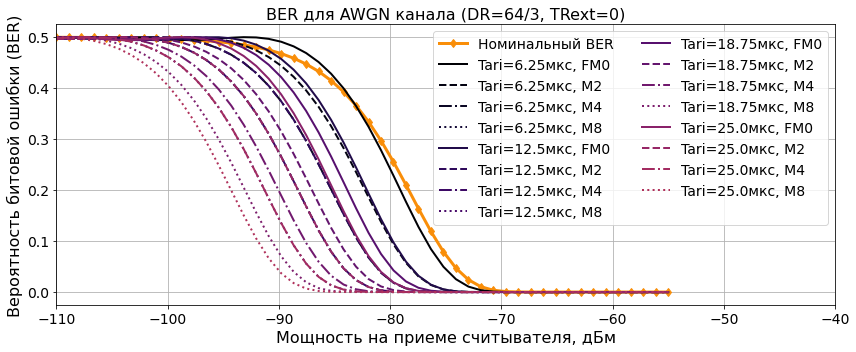

In [57]:
from itertools import product

STRINGS = {
    'title': {
        'rus': 'BER для AWGN канала (DR=64/3, TRext=0)',
        'eng': 'BER for AWGN channel (DR=64/3, TRext=0)',
    },
    'nominal': {
        'rus': 'Номинальный BER',
        'eng': 'Nominal BER',
    },
    'us': {'rus': 'мкс', 'eng': 'us'},
    'x-axis': {
        'rus': 'Мощность на приеме считывателя, дБм',
        'eng': 'RX power at reader, dBm',
    },
    'y-axis': {'rus': 'Вероятность битовой ошибки (BER)', 'eng': 'BER'}
}

SIGNAL = np.linspace(-110.0, -55.0, 50)
SNR = [signal2noise(s, NOISE) for s in SIGNAL]

fig, ax0 = plt.subplots(ncols=1, nrows=1, figsize=(12,5))

raw_ber = [ber_over_awgn(v) for v in SNR]
ax0.plot(SIGNAL, raw_ber, label=STRINGS['nominal'][LANG], 
         linestyle='-', linewidth=3, marker='d', color=CMAP(0.75))

all_ext_snr_params = list(product(zip(TARIS, TRCALS), TAG_ENCS))
for i, ((tari, trcal), m) in enumerate(all_ext_snr_params):
    color = CMAP(i / (2* len(all_ext_snr_params)))
    snr = get_snr_ext(SNR, m=m, trext=False, tari=tari, trcal=trcal, dr=DR.DR_643)
    ber = [ber_over_awgn(v) for v in snr]
    linestyle = {
        TagEncoding.FM0: '-',
        TagEncoding.M2: '--',
        TagEncoding.M4: '-.',
        TagEncoding.M8: ':',
    }[m]
    ax0.plot(SIGNAL, ber,
            label=f'Tari={tari*1e6}{STRINGS["us"][LANG]}, {m.name}',
            color=color, linewidth=2, linestyle=linestyle)

ax0.grid()
ax0.legend(ncol=2, fontsize=14)
ax0.set_title(
    STRINGS['title'][LANG],
    fontsize=16
)
ax0.set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
ax0.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
ax0.tick_params(labelsize=14)
ax0.set_xlim((-110, -40))
plt.tight_layout()
plt.savefig(f'plots/ber_vs_snr_different_links_{LANG}.pdf')

In [60]:
BER_MAP_SERIES = (
    {'tari': TARIS[0], 'trcal': TRCALS[0], 'm': TagEncoding.FM0},
    {'tari': TARIS[1], 'trcal': TRCALS[1], 'm': TagEncoding.M2},
)

BER_MAP_POWER = np.linspace(15, 33, 200)
BER_MAP_ALT = np.linspace(1, 25, 200)
BER_MAP_DX = np.linspace(0, 10, 200)

In [61]:
BER_MAP_DX_POINTS = (0, 1.0, 2.0, 3.0, 4.0)

def get_ber_map_at_dx(dx, power_list, alt_list, tari, trcal, m, dr=DR.DR_643, wavelen=WAVELEN):
    ber = np.zeros((len(power_list), len(alt_list)))
    points = list(product(enumerate(power_list), enumerate(alt_list)))
    for (i, p), (j, a) in tqdm_notebook(points, desc="Estimating BER", leave=False):
        rx = estimate_power([dx], a, p, wavelen).reader_rx[0]
        snr = signal2noise(rx, NOISE)
        snr_ext = get_snr_ext([snr], m=m, trext=False, tari=tari, trcal=trcal, dr=dr)[0]
        ber[j, i] = ber_over_awgn(snr_ext)
    return ber

BER_MAPS_XP = [
    [
        get_ber_map_at_dx(
            d, BER_MAP_POWER, BER_MAP_ALT, 
            tari=series['tari'], 
            trcal=series['trcal'], 
            m=series['m']
        ) for d in tqdm_notebook(BER_MAP_DX_POINTS, leave=False, desc="DX offsets")
    ] for series in tqdm_notebook(BER_MAP_SERIES, desc="Settings")
]

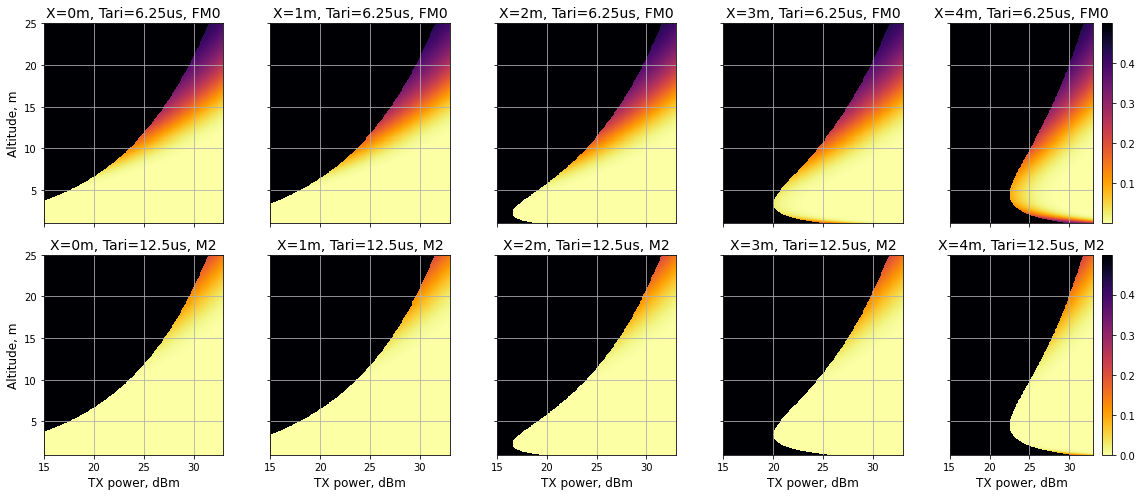

In [45]:
cmap = 'inferno_r'
fig, axes = plt.subplots(ncols=len(BER_MAP_DX_POINTS), nrows=len(BER_MAP_SERIES), 
                         figsize=(16, 7), sharey=True, sharex=True)
for i, series in enumerate(BER_MAP_SERIES):
    for j, dx in enumerate(BER_MAP_DX_POINTS):
        ax = axes[i][j]
        im = ax.pcolormesh(BER_MAP_POWER, BER_MAP_ALT, BER_MAPS_XP[i][j], cmap=cmap)
        if j == len(BER_MAP_DX_POINTS) - 1:
            fig.colorbar(im, ax=ax)
        ax.grid()
        ax.set_title(f'X={dx:.0f}m, Tari={series["tari"]*1e6}us, {series["m"].name}',
                    fontsize=14)

for i, _ in enumerate(BER_MAP_SERIES):
    axes[i][0].set_ylabel('Altitude, m', fontsize=12)
for j, _ in enumerate(BER_MAP_DX_POINTS):
    axes[-1][j].set_xlabel('TX power, dBm', fontsize=12)
plt.tight_layout()

In [46]:
BER_MAP_ALT_POINTS = (2, 6, 10, 14, 18)

def get_ber_map_at_altitude(altitude, power_list, dx_list, tari, trcal, m, dr=DR.DR_643, wavelen=WAVELEN):
    ber = np.zeros((len(power_list), len(dx_list)))
    points = list(enumerate(power_list))
    for (i, p) in tqdm_notebook(points, desc="Estimating BER", leave=False):
        rx = estimate_power(dx_list, altitude, p, wavelen).reader_rx
        for j, _ in enumerate(dx_list):
            snr = signal2noise(rx[j], NOISE)
            snr_ext = get_snr_ext([snr], m=m, trext=False, tari=tari, trcal=trcal, dr=dr)[0]
            ber[j, i] = ber_over_awgn(snr_ext)
    return ber

BER_MAPS_AP = [
    [
        get_ber_map_at_altitude(
            alt, BER_MAP_POWER, BER_MAP_DX, 
            tari=series['tari'], 
            trcal=series['trcal'], 
            m=series['m']
        ) for alt in tqdm_notebook(BER_MAP_ALT_POINTS, leave=False, desc="Altitudes")
    ] for series in tqdm_notebook(BER_MAP_SERIES, desc="Settings")
]

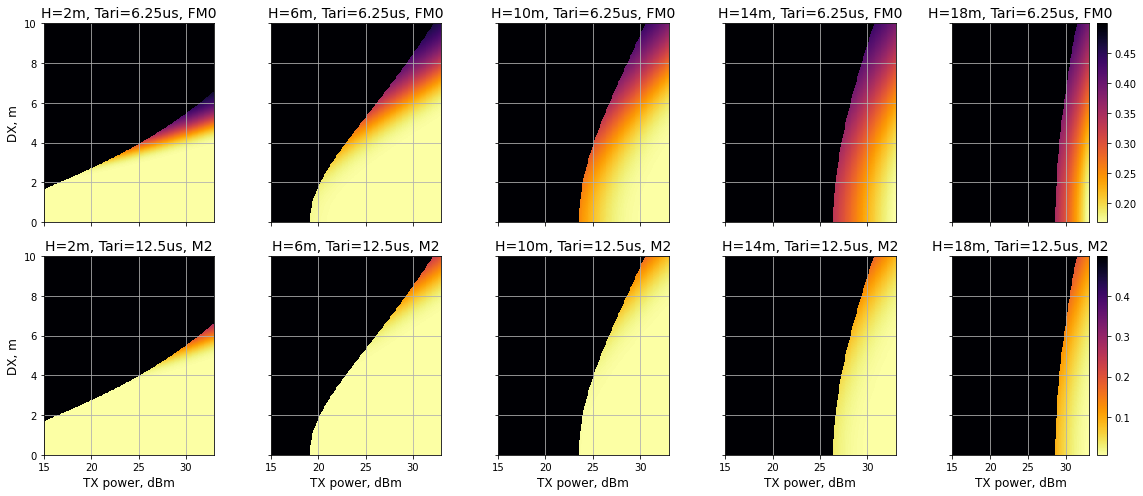

In [47]:
cmap = 'inferno_r'
fig, axes = plt.subplots(ncols=len(BER_MAP_ALT_POINTS), nrows=len(BER_MAP_SERIES), 
                         figsize=(16, 7), sharey=True, sharex=True)
for i, series in enumerate(BER_MAP_SERIES):
    for j, alt in enumerate(BER_MAP_ALT_POINTS):
        ax = axes[i][j]
        im = ax.pcolormesh(BER_MAP_POWER, BER_MAP_DX, BER_MAPS_AP[i][j], cmap=cmap)
        if j == len(BER_MAP_ALT_POINTS) - 1:
            fig.colorbar(im, ax=ax)
        ax.grid()
        ax.set_title(f'H={alt:.0f}m, Tari={series["tari"]*1e6}us, {series["m"].name}',
                    fontsize=14)

for i, _ in enumerate(BER_MAP_SERIES):
    axes[i][0].set_ylabel('DX, m', fontsize=12)
for j, _ in enumerate(BER_MAP_ALT_POINTS):
    axes[-1][j].set_xlabel('TX power, dBm', fontsize=12)
plt.tight_layout()

In [48]:
BER_MAP_POWER_POINTS = (15, 19, 23, 27, 31)

def get_ber_map_at_power(power, dx_list, alt_list, tari, trcal, m, dr=DR.DR_643, wavelen=WAVELEN):
    ber = np.zeros((len(dx_list), len(alt_list)))
    for (i, h) in tqdm_notebook(list(enumerate(alt_list)), desc="Estimating BER", leave=False):
        rx = estimate_power(dx_list, h, power, wavelen).reader_rx
        for j, _ in enumerate(dx_list):
            snr = signal2noise(rx[j], NOISE)
            snr_ext = get_snr_ext([snr], m=m, trext=False, tari=tari, trcal=trcal, dr=dr)[0]
            ber[i, j] = ber_over_awgn(snr_ext)
    return ber

BER_MAPS_AX = [
    [
        get_ber_map_at_power(
            power, BER_MAP_DX, BER_MAP_ALT, 
            tari=series['tari'], 
            trcal=series['trcal'], 
            m=series['m']
        ) for power in tqdm_notebook(BER_MAP_POWER_POINTS, leave=False, desc="Power")
    ] for series in tqdm_notebook(BER_MAP_SERIES, desc="Settings")
]

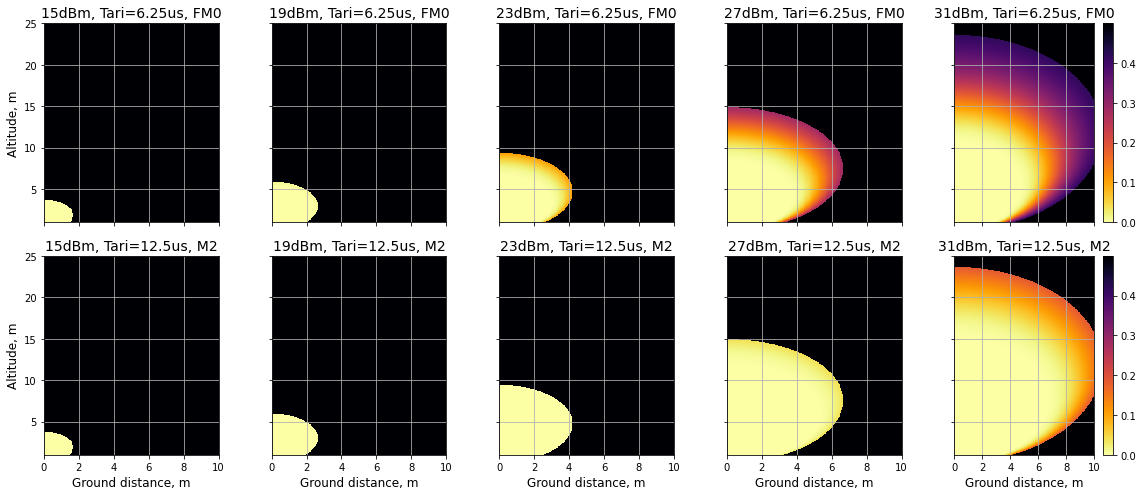

In [49]:
cmap = 'inferno_r'
fig, axes = plt.subplots(ncols=len(BER_MAP_POWER_POINTS), nrows=len(BER_MAP_SERIES), 
                         figsize=(16, 7), sharey=True, sharex=True)
for i, series in enumerate(BER_MAP_SERIES):
    for j, power in enumerate(BER_MAP_POWER_POINTS):
        ax = axes[i][j]
        im = ax.pcolormesh(BER_MAP_DX, BER_MAP_ALT, BER_MAPS_AX[i][j], cmap=cmap)
        if j == len(BER_MAP_POWER_POINTS) - 1:
            fig.colorbar(im, ax=ax)
        ax.grid()
        ax.set_title(f'{power:.0f}dBm, Tari={series["tari"]*1e6}us, {series["m"].name}',
                    fontsize=14)

for i, _ in enumerate(BER_MAP_SERIES):
    axes[i][0].set_ylabel('Altitude, m', fontsize=12)
for j, _ in enumerate(BER_MAP_POWER_POINTS):
    axes[-1][j].set_xlabel('Ground distance, m', fontsize=12)
plt.tight_layout()

In [62]:
def estimate_reader_rx_power(dx, dh, power, wavelen):
    dr = (dx**2 + dh**2)**0.5
    pl = lin2db(free_space_path_loss(dr, dh, wavelen, rp_rx=dipole_rp, rp_tx=dipole_rp))    
    tag_rx = get_tag_rx_power(dx, dh, power, wavelen, pl=pl)
    tag_tx = get_tag_tx_power(tag_rx, truncate=True)
    reader_rx = get_reader_rx_power(dx, dh, tag_tx, wavelen, truncate=True)
    return reader_rx
    
    
def estimate_min_power(dx, dh, tari, trcal, m, dr=DR.DR_643, wavelen=WAVELEN, max_ber=0.01, step=0.1, 
                       start_power=5.0):
    tx_power = start_power
    ber = 0.5
    while ber > max_ber >= 0:
        rx_power = estimate_reader_rx_power(dx, dh, tx_power, wavelen=wavelen)
        snr = signal2noise(rx_power, NOISE)
        snr_ext = get_snr_ext([snr], m=m, trext=False, tari=tari, trcal=trcal, dr=dr)[0]
        ber = ber_over_awgn(snr_ext)
        if ber > max_ber:
            tx_power += step
    return tx_power

def estimate_min_power_map(X, H, tari, trcal, m, dr=DR.DR_643, wavelen=WAVELEN, 
                           max_ber=0.01, step=0.1, start_power=5.0):
    pmap = np.zeros((len(H), len(X)))
    mesh = product(enumerate(H), enumerate(X))
    for (i, dh), (j, dx) in tqdm_notebook(list(mesh), leave=False):
        pmap[i][j] = estimate_min_power(dx, dh, tari, trcal, m, dr=dr, wavelen=wavelen,
                                       max_ber=max_ber, step=step, start_power=start_power)
    return pmap

In [63]:
DX = np.linspace(0, 7, 100)
DH = np.linspace(1, 17, 100)
MAX_BER_POINTS = np.asarray((0.0001, 0.001, 0.01))
MIN_POWER_MAPS = [[
    estimate_min_power_map(
        X=DX,
        H=DH,
        tari=series['tari'],
        trcal=series['trcal'],
        m=series['m'],
        step=0.1,
        max_ber=max_ber
    ) for max_ber in tqdm_notebook(MAX_BER_POINTS, leave=False, desc="Max. BER")
]  for series in tqdm_notebook(BER_MAP_SERIES, desc="Settings")]

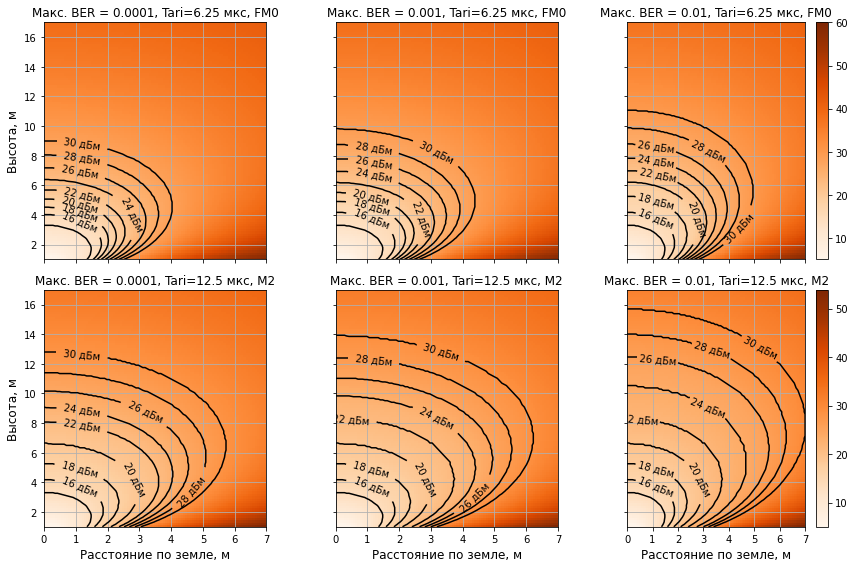

In [111]:
STRINGS = {
    'max': {'rus': 'Макс.', 'eng': 'MAX'},
    'us': {'rus': 'мкс', 'eng': 'us'},
    'dbm': {'rus': 'дБм', 'eng': 'dBm'},
    'y-axis': {'rus': 'Высота, м', 'eng': 'Altitude, m'},
    'x-axis': {'rus': 'Расстояние по земле, м', 'eng': 'Ground distance, m'}
}
fig, axes = plt.subplots(nrows=len(BER_MAP_SERIES), ncols=len(MAX_BER_POINTS), 
                         figsize=(12,8), sharey=True, sharex=True)
for j, max_ber in enumerate(MAX_BER_POINTS):
    for i, series in enumerate(BER_MAP_SERIES):
        ax = axes[i][j]
        pmap = MIN_POWER_MAPS[i][j]
        im = ax.pcolormesh(DX, DH, pmap, cmap='Oranges')
        cs = ax.contour(DX, DH, pmap, levels=np.arange(14, 32, 2), colors='k')
        plt.clabel(cs, inline=1, fmt=f"%.0f {STRINGS['dbm'][LANG]}")
        if j == len(MAX_BER_POINTS)-1:
            fig.colorbar(im, ax=ax)
        ax.grid()
        ax.set_title(
            f"{STRINGS['max'][LANG]} BER = {max_ber}, "
            f"Tari={series['tari']*1e6} {STRINGS['us'][LANG]}, "
            f"{series['m'].name}")
for i, series in enumerate(BER_MAP_SERIES):
    axes[i][0].set_ylabel(STRINGS['y-axis'][LANG], fontsize=12)
for j in range(len(MAX_BER_POINTS)):
    axes[-1][j].set_xlabel(STRINGS['x-axis'][LANG], fontsize=12)
plt.tight_layout()
plt.savefig(f'plots/min_power_vs_x_h_and_ber_{LANG}.pdf')

## Round analysis

### Round structure

We assume that only one RFID tag is in the reader area and no collisions take place and `Q` may be set to 0. However, due to high BER errors in tag responses may take place.

First, we will describe the round structure. Then, we will estimate the probability of a successful data reception depending on the data length and BER. Finally, we will analyze the round duration under the given BER values.

Regarding tag responses transmission errors which occur due to non-zero BER, we consider three strategies:

1. On any error, the reader starts a new round.
2. After any error, the reader re-sends the previous command until either succesful response is received, or the tag is lost and no response received at all. When reading data, all words are requested in a single `Read` command.
3. The same as the second one, but data is read in chunks: the reader sends a number of `Read` commands requesting a small number of words (typically, one or two) and moving `WordPtr` until all requested data is received. In case of error, only the last words are re-sent.

![Round structure](img/ROUND_STRUCTURE.png)

The first strategy may be suitable when identifying fast-moving targets with non-zero collision probability [IEEE_JRFID_LARIONOV]. However, it is expected to provide the poorest results in our current scenario and is considered just as a reference, since the UAV speed is not high and any error result in the need to re-send all previous commands and responses.

The second and the third strategies differ in how data from the RFID-sensor is read. Consider that the reader need to get, say, 10 words. In the second strategy, it will issue only one `Read` command. The tag will then send 10 words and 33 bits in service fields (`Header`, `RN` and `CRC`). If everything is fine and the response is received, `10 * 16 + 33 = 193 bits` will be transmitted in total. However, if an error occurs, the tag will need to re-send all `193 bits`. again. In contrast, in the third strategy the reader requests small chunks of data (say, 2 words per chunk), thus minimising the amount of retransmitted data in case of error. In this example, the tag will need to send at least five responses with 2 words in each. Note, that additional service fields are transmitted in each response, so totally the tag will transmit `(2 * 16 + 33) * 5 = 325 bits`. If one error occurs, tag will retransmit only one response (`65 bits`). Thus, in case of no errors, the second strategy wins with `193 bits` versus `325 bits` in the third, result is almost equal in case of one error (`386 bits` versus `390 bits`), and in case of two errors the third strategy wins with `455 bits` vs. `579 bits`. It should be also noted, that absolute error of one response attempt is much less in case of the third strategy.

![Read strategies](img/READ_SCENARIOS.png)

### Round duration estimation

To understand the dependency between the protocol settings, selected read strategy and round duration, we simulate a number of rounds with various parameters.

In [67]:
from model.c1g2.commands import ReaderFrame, ReaderPreamble, ReaderSync, Query, Ack, ReqRn, Read
from model.c1g2.replies import TagFrame, TagPreamble, RN16, EPC, Handle, Data
from model.c1g2.symbols import get_blf, min_t1, max_t1, min_t2, max_t2, t3, DR, TagEncoding

In [68]:
class RoundEstimator:
    def __init__(self, num_words, tari, m, dr=DR.DR_643, trext=False):
        self.num_words = num_words
        self.tari = tari
        self.m = m
        self.dr = dr
        self.trext = trext
        
        # Estimating RTcal, TRcal, BLF, T1, T2, T3:
        self.rtcal = tari * 2.5
        self.trcal = self.rtcal * 2
        self.blf = get_blf(dr, self.trcal)
        self.min_t1 = min_t1(self.rtcal, self.blf)
        self.max_t1 = max_t1(self.rtcal, self.blf)
        self.min_t2 = min_t2(self.blf)
        self.max_t2 = max_t2(self.blf)
        self.t3 = t3()
        
        # Building commands:
        self.reader_preamble = ReaderPreamble(tari, self.rtcal, self.trcal)
        self.reader_sync = ReaderSync(tari, self.rtcal)
        self.query = ReaderFrame(self.reader_preamble, Query(q=0, m=m, dr=dr, trext=trext))
        self.ack = ReaderFrame(self.reader_sync, Ack())
        self.req_rn = ReaderFrame(self.reader_sync, ReqRn())
        self.read = ReaderFrame(self.reader_sync, self.build_read_command())

        # Building replies:
        self.tag_preamble = TagPreamble(m, trext=trext, blf=self.blf)
        self.rn16 = TagFrame(self.tag_preamble, RN16())
        self.epcid = TagFrame(self.tag_preamble, EPC())
        self.handle = TagFrame(self.tag_preamble, Handle())
        self.data = TagFrame(self.tag_preamble, self.build_read_response())
    
    def build_read_command(self):
        return Read(wordcnt=self.num_words)
        
    def build_read_response(self):
        return Data('ABCD' * self.num_words)
    
    def simulate_single_round(self, ber):
        raise NotImplementedError
    
    def average_results(self, results):
        return np.mean(results), np.std(results)
    
    def __call__(self, ber, num_iterations=100, desc=None, leave=False):
        results = []
        a_range = range(num_iterations) if desc is None else tnrange(num_iterations, desc=desc, leave=leave)
        for _ in a_range:
            ret = self.simulate_single_round(ber)
            if ret < np.inf:
                results.append(ret)
        return *self.average_results(results), results

In [69]:
class RandomValues:
    WINDOW_SIZE = 1000
    
    def __init__(self, fn):
        self.fn = fn
        self.intervals = []
        self.index = 0

    def get(self):
        if self.index >= len(self.intervals):
            self.intervals = self.fn(RandomValues.WINDOW_SIZE)
            self.index = 0
        x = self.intervals[self.index]
        self.index += 1
        return x

RANDOM_01 = RandomValues(np.random.rand)

def random_success_rx(ber, frame):
    p = (1.0 - ber) ** frame.reply.bitlen
    return RANDOM_01.get() <= p

In [70]:
class NoRetransRoundDurationEstimator(RoundEstimator):
    def __init__(self, num_words, tari, m, dr=DR.DR_643, trext=False, max_t=5):
        super().__init__(num_words, tari, m, dr=dr, trext=trext)
        self.max_t = max_t
    
    def simulate_single_round(self, ber):
        t = 0
        received_data = False
        while not received_data:
            
            received_handle = False
            while not received_handle:
        
                received_epcid = False
                while not received_epcid:
    
                    received_rn16 = False
                    while not received_rn16:
                        t += self.query.duration + self.min_t1 + self.rn16.duration + self.min_t2
                        received_rn16 = random_success_rx(ber, self.rn16)
                        if t > self.max_t:
                            return np.inf
                    
                    t += self.ack.duration + self.min_t1 + self.epcid.duration + self.min_t2
                    received_epcid = random_success_rx(ber, self.epcid)
                
                t += self.req_rn.duration + self.min_t1 + self.handle.duration + self.min_t2
                received_handle = random_success_rx(ber, self.handle)
            
            t += self.read.duration + self.min_t1 + self.data.duration + self.min_t2
            received_data = random_success_rx(ber, self.data)
        
        return t

In [71]:
class RetransRoundDurationEstimator(RoundEstimator):
    def __init__(self, num_words, tari, m, dr=DR.DR_643, trext=False):
        super().__init__(num_words, tari, m, dr=dr, trext=trext)
    
    def simulate_single_round(self, ber):
        t = 0

        received_rn16 = False
        received_epcid = False
        received_handle = False
        received_data = False

        while not received_rn16:
            t += self.query.duration + self.min_t1 + self.rn16.duration + self.min_t2
            received_rn16 = random_success_rx(ber, self.rn16)

        while not received_epcid:
            t += self.ack.duration + self.min_t1 + self.epcid.duration + self.min_t2
            received_epcid = random_success_rx(ber, self.epcid)

        while not received_handle:
            t += self.req_rn.duration + self.min_t1 + self.handle.duration + self.min_t2
            received_handle = random_success_rx(ber, self.handle)
            
        while not received_data:
            t += self.read.duration + self.min_t1 + self.data.duration + self.min_t2
            received_data = random_success_rx(ber, self.data)
                    
        return t

In [72]:
class ChunkDataRoundDurationEstimator(RoundEstimator):
    def __init__(self, num_words, tari, m, dr=DR.DR_643, trext=False, chunk_num_words=2):
        self.chunk_num_words = chunk_num_words
        super().__init__(num_words, tari, m, dr=dr, trext=trext)

        if (rest := num_words % chunk_num_words) != 0:
            self.last_read = ReaderFrame(self.reader_sync, Read(wordcnt=rest))
            self.last_data = TagFrame(self.tag_preamble, Data('EEFF' * rest))
        else:
            self.last_read, self.last_data = None, None
    
    def build_read_command(self):
        return Read(wordcnt=self.chunk_num_words)
    
    def build_read_response(self):
        return Data('ABCD' * self.chunk_num_words)
    
    def simulate_single_round(self, ber):
        t = 0

        received_rn16 = False
        received_epcid = False
        received_handle = False

        while not received_rn16:
            t += self.query.duration + self.min_t1 + self.rn16.duration + self.min_t2
            received_rn16 = random_success_rx(ber, self.rn16)

        while not received_epcid:
            t += self.ack.duration + self.min_t1 + self.epcid.duration + self.min_t2
            received_epcid = random_success_rx(ber, self.epcid)

        while not received_handle:
            t += self.req_rn.duration + self.min_t1 + self.handle.duration + self.min_t2
            received_handle = random_success_rx(ber, self.handle)
        
        num_reads = self.num_words // self.chunk_num_words
        while num_reads > 0:
            received_data = False
            while not received_data:
                t += self.read.duration + self.min_t1 + self.data.duration + self.min_t2
                received_data = random_success_rx(ber, self.data)
            num_reads -= 1
        
        if self.last_read is not None:
            received_last_data = False
            while not received_last_data:
                t += self.last_read.duration + self.min_t1 + self.last_data.duration + self.min_t2
                received_last_data = random_success_rx(ber, self.last_data)

        return t

#### Estimating round duration against BER

In [73]:
BER = np.linspace(0, 0.01, 20)
NUM_WORDS = [2, 4, 8, 16, 32, 64]
LINK = {'tari': 12.5e-6, 'm': TagEncoding.M4, 'trext': False}
NUM_ITERATIONS = 1000

ESTIMATORS = [
    [NoRetransRoundDurationEstimator(num_words=nw, **LINK) for nw in NUM_WORDS],
    [RetransRoundDurationEstimator(num_words=nw, **LINK) for nw in NUM_WORDS],
    [ChunkDataRoundDurationEstimator(num_words=nw, **LINK) for nw in NUM_WORDS],
]

In [74]:
DURATIONS = [
    [
        [ESTIMATORS[i][j](ber, num_iterations=NUM_ITERATIONS)[:-1] for ber in BER]
        for j in tnrange(len(NUM_WORDS), desc='num words', leave=False)
    ] for i in tnrange(3, desc='scenario')
]

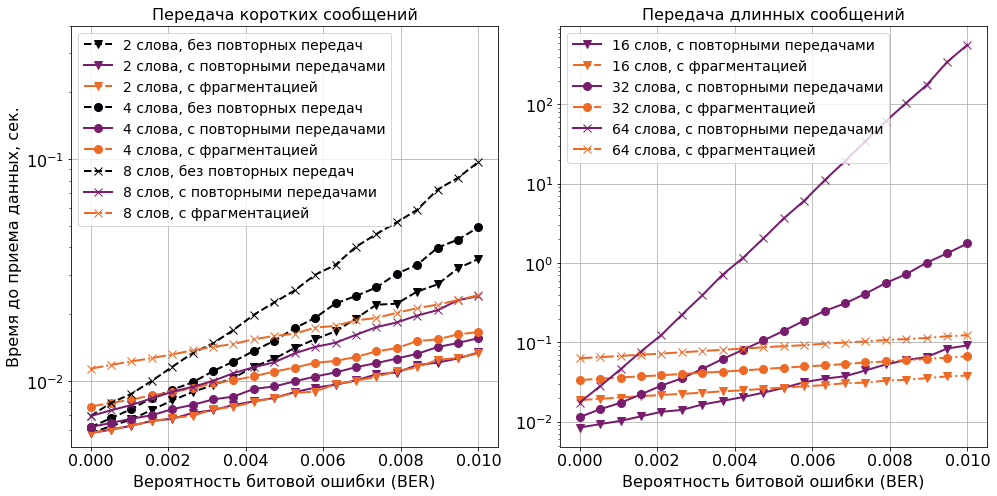

In [98]:
_cmap = get_cmap('inferno')

NW_LOW_INDEX = 3
SCENARIO_TITLES = [
    'legend-no-retrans',
    'legend-retrans',
    'legend-chunks',
]
STRINGS = {
    'legend-no-retrans': {'rus': 'без повторных передач', 'eng': 'no retransmissions'},
    'legend-retrans': {'rus': 'с повторными передачами', 'eng': 'retransmitting'},
    'legend-chunks': {'rus': 'с фрагментацией', 'eng': 'data in chunks'},
    'title-small': {
        'eng': "Small data transmissions",
        'rus': "Передача коротких сообщений",
    },
    'title-larger': {
        'eng': "Larger data transmission",
        'rus': "Передача длинных сообщений",
    },
    'x-axis': {'rus': 'Вероятность битовой ошибки (BER)', 'eng': 'BER'},
    'y-axis': {'rus': 'Время до приема данных, сек.', 'eng': 'Time till data reception, sec.'},
    'words': {'rus': 'слов', 'eng': 'word'},
}
MARKERS = ('v', 'o', 'x')
LINESTYLES = ('--', '-', '-.')

def get_word_plural(num_words):
    r = num_words % 10
    if r == 1:
        return 'o' if LANG == 'rus' else ''
    if LANG == 'eng':
        return 's'
    if r in [2, 3, 4]:
        return 'a'
    return ''


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7), sharex=True)

NW_LIMITS = (0, NW_LOW_INDEX)

for ax_ix, (ax, nw_base, scenarios) in enumerate(zip(axes, NW_LIMITS, (range(3), range(1,3)))):
    nw_max = len(NUM_WORDS) if ax_ix == len(axes)-1 else NW_LIMITS[ax_ix + 1]
    words = NUM_WORDS[nw_base : nw_max]

    for nw_ix, num_words in enumerate(words):
        marker = MARKERS[nw_ix]
        plur = get_word_plural(num_words)
        
        for sc_ix in scenarios:
            values = [r[0] for r in DURATIONS[sc_ix][nw_ix + nw_base]]

            color, ls = _cmap(sc_ix / (len(words))), LINESTYLES[sc_ix]
            label = f'{num_words} {STRINGS["words"][LANG]}{plur}, {STRINGS[SCENARIO_TITLES[sc_ix]][LANG]}'
            
            ax.plot(BER, values, label=label, color=color, linewidth=2, linestyle=ls, marker=marker, ms=8)

    ax.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
    ax.legend(fontsize=14)
    ax.grid()
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)

axes[0].set_ylim((None, 0.4))
axes[0].set_title(STRINGS['title-small'][LANG], fontsize=16)
axes[0].set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
axes[1].set_title(STRINGS['title-larger'][LANG], fontsize=16)

plt.tight_layout()
plt.savefig(f'plots/ttdr_by_nw_{LANG}.pdf')

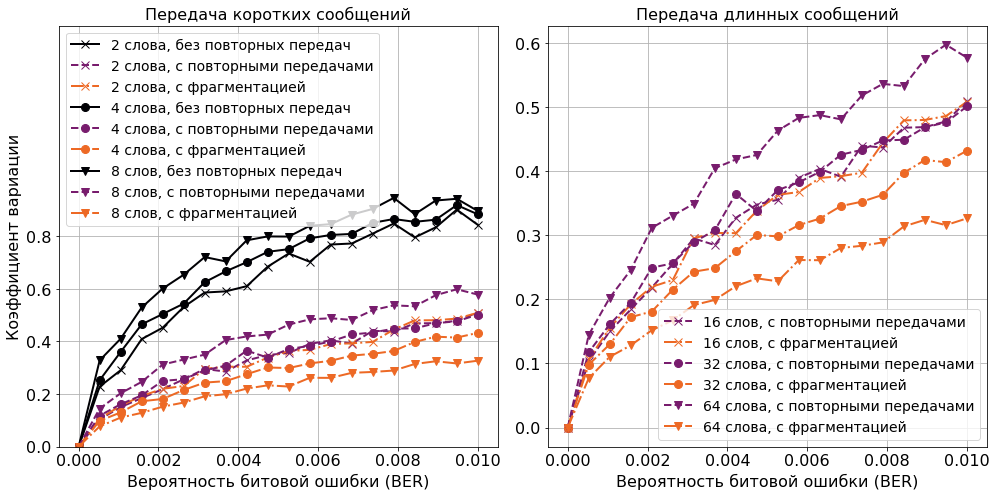

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

MAX_NW_IX = 3  # 8 words

MARKERS = ['x', 'o', 'v']
LINESTYLES = ['-', '--', '-.']
STRINGS = {
    'legend-no-retrans': {'rus': 'без повторных передач', 'eng': 'no retransmissions'},
    'legend-retrans': {'rus': 'с повторными передачами', 'eng': 'retransmitting'},
    'legend-chunks': {'rus': 'с фрагментацией', 'eng': 'data in chunks'},
    'title-small': {
        'eng': "Small data transmissions",
        'rus': "Передача коротких сообщений",
    },
    'title-larger': {
        'eng': "Larger data transmission",
        'rus': "Передача длинных сообщений",
    },
    'x-axis': {'rus': 'Вероятность битовой ошибки (BER)', 'eng': 'BER'},
    'y-axis': {'rus': 'Коэффициент вариации', 'eng': 'Variation (std / mean)'},
    'words': {'rus': 'слов', 'eng': 'word'},
}

def _get_var_koefs(sc_ix, nw_ix):
    values = np.asarray([r[0] for r in DURATIONS[sc_ix][nw_ix]])
    errs = np.asarray([r[1] for r in DURATIONS[sc_ix][nw_ix]])
    return errs / values

for ax_ix, (ax, nw_base, scenarios) in enumerate(zip(axes, NW_LIMITS, (range(3), range(1,3)))):
    nw_max = len(NUM_WORDS) if ax_ix == len(axes)-1 else NW_LIMITS[ax_ix + 1]
    words = NUM_WORDS[nw_base : nw_max]

    for nw_ix, num_words in enumerate(words):
        marker = MARKERS[nw_ix]
        plur = get_word_plural(num_words)
        
        for sc_ix in scenarios:
            values = _get_var_koefs(sc_ix, nw_ix)

            color, ls = _cmap(sc_ix / (len(words))), LINESTYLES[sc_ix]
            label = f'{num_words} {STRINGS["words"][LANG]}{plur}, {STRINGS[SCENARIO_TITLES[sc_ix]][LANG]}'
            
            ax.plot(BER, values, label=label, color=color, linewidth=2, linestyle=ls, marker=marker, ms=8)

    ax.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
    ax.legend(fontsize=14)
    ax.tick_params(labelsize=16)
    ax.grid()

axes[0].set_yticks((0, 0.2, 0.4, 0.6, 0.8))
axes[0].set_ylim((0, 1.6))
axes[0].set_title(STRINGS['title-small'][LANG], fontsize=16)
axes[0].set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
axes[1].set_title(STRINGS['title-larger'][LANG], fontsize=16)

plt.tight_layout()
plt.savefig(f'plots/ttdr_var_by_nw_{LANG}.pdf')

### Read duration dependency on link settings

In [105]:
TARIS = [6.25e-6, 12.5e-6, 18.75e-6, 25e-6]
ENCODINGS = [TagEncoding.FM0, TagEncoding.M2, TagEncoding.M4, TagEncoding.M8]

LINKS_BY_TARI = [{'tari': tari, 'm': TagEncoding.FM0, 'trext': False} for tari in TARIS]
LINKS_BY_M = [{'tari': 6.25e-6, 'm': m, 'trext': False} for m in ENCODINGS]
LINKS_EXT = [{'tari': tari, 'm': m, 'trext': True} for (tari, m) in zip(TARIS, ENCODINGS)]

LINKS_2 = [
    LINKS_BY_TARI,
    LINKS_BY_M,
    LINKS_EXT,
]

ESTIMATORS_2 = [
    [ChunkDataRoundDurationEstimator(num_words=64, **link) for link in LINKS_BY_TARI],
    [ChunkDataRoundDurationEstimator(num_words=64, **link) for link in LINKS_BY_M],
    [ChunkDataRoundDurationEstimator(num_words=64, **link) for link in LINKS_EXT]
]

DURATIONS_2 = [
    [
        [ESTIMATORS_2[i][j](ber, num_iterations=NUM_ITERATIONS)[:-1] for ber in BER]
        for j in tnrange(len(LINKS_2[i]), desc='link settings', leave=False)
    ] for i in tnrange(len(LINKS_2), desc='scenario')    
]

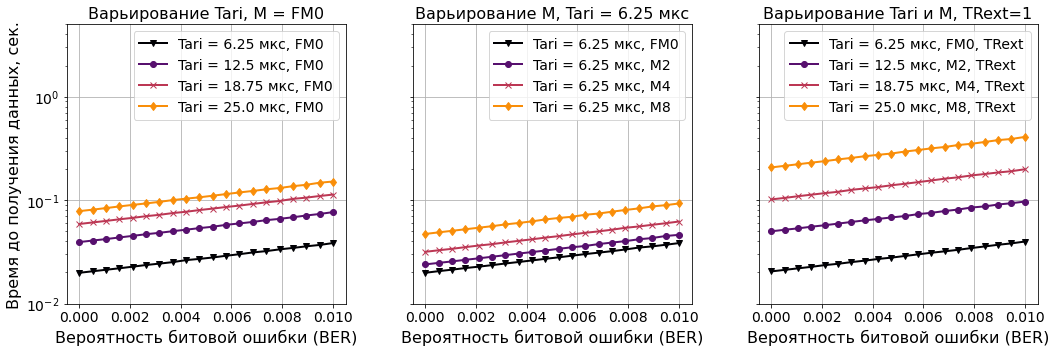

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=len(LINKS_2), 
                         figsize=(15, 5), sharey=True)

MARKERS = ('v', 'o', 'x', 'd')
STRINGS = {
    'us': {'rus': 'мкс', 'eng': 'us'},
    'title-vary-tari': {
        'eng': "Varying Tari with FM0",
        'rus': "Варьирование Tari, M = FM0",
    },
    'title-vary-m': {
        'eng': "Varying M with Tari = 6.25 us",
        'rus': "Варьирование M, Tari = 6.25 мкс",
    },
    'title-vary-both': {
        'eng': 'Varying both Tari and M with TRext=1',
        'rus': 'Варьирование Tari и M, TRext=1',
    },
    'x-axis': {'rus': 'Вероятность битовой ошибки (BER)', 'eng': 'BER'},
    'y-axis': {'rus': 'Время до получения данных, сек.', 'eng': 'Time till data reception, sec.'},
}
LINKS_2_TITLES = [
    "title-vary-tari",
    "title-vary-m",
    "title-vary-both",
]

for i, links in enumerate(LINKS_2):
    ax = axes[i]
    for j, link in enumerate(links):
        s_trext = "" if not link["trext"] else ", TRext"
        label = f'Tari = {link["tari"]*1e6} {STRINGS["us"][LANG]}, {link["m"].name}{s_trext}'
        color = CMAP(j / (len(links)))

        values = [r[0] for r in DURATIONS_2[i][j]]
        ax.plot(BER, values, label=label,
                color=color, linewidth=2, marker=MARKERS[j % len(MARKERS)])
        
    ax.grid()
    ax.set_xlabel(STRINGS['x-axis'][LANG], fontsize=16)
    ax.set_title(STRINGS[LINKS_2_TITLES[i]][LANG], fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    ax.set_yscale('log')
    ax.set_ylim((1e-2, 5))

axes[0].set_ylabel(STRINGS['y-axis'][LANG], fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/ttdr_frag_by_links_{LANG}.pdf')